In [1]:
from IPython.display import HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from copy import deepcopy
import datetime
import calendar

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from lightgbm import Dataset


In [5]:
import sys
sys.path.append('../..')
from utils.analyze import compute_metrics
from utils.metrics import Bias, Wape, Count, Sum, Mape, MSE

### Данные

In [6]:
! ls data

df.csv	extened_df.csv	predict_example.csv  test.csv  train.csv


In [7]:
data = pd.read_csv('data/train.csv')
data['dt'] = pd.to_datetime(data['dt'])

In [8]:
test_data = pd.read_csv('data/test.csv')

In [9]:
predict_example = pd.read_csv('data/predict_example.csv')

### Constants

In [10]:

mode = 'train' #

if mode == 'submit':
    TRIGGER_DATE = pd.to_datetime('2017-07-01') # первый день для прогноза
    HORIZON = 31
else:
    TRIGGER_DATE = pd.to_datetime('2017-06-01')
    HORIZON = 30

START_TRAIN_DATE = pd.to_datetime('2016-01-02')
END_TRAIN_DATE = TRIGGER_DATE - DateOffset(days=1)

START_PREDICT_DATE = TRIGGER_DATE
END_PREDICT_DATE = TRIGGER_DATE + DateOffset(months=1) - DateOffset(days=1)

print('Mode', mode)
print('TRIGGER data:', TRIGGER_DATE)
print('Start train data:', START_TRAIN_DATE)
print('End train data:', END_TRAIN_DATE)
print('Start predict data:', START_PREDICT_DATE)
print('End predict data:', END_PREDICT_DATE)

Mode train
TRIGGER data: 2017-06-01 00:00:00
Start train data: 2016-01-02 00:00:00
End train data: 2017-05-31 00:00:00
Start predict data: 2017-06-01 00:00:00
End predict data: 2017-06-30 00:00:00


In [11]:
# create grid
range_date = pd.date_range(START_TRAIN_DATE, END_PREDICT_DATE, freq='D')
unique_shop_id = data['id'].unique().tolist()


train_grid = pd.DataFrame(list(product(unique_shop_id,
                                       range_date)),
                      columns = ['id', 'dt'])

df = train_grid.merge(data, how = 'left', on = ['id', 'dt'])

In [12]:
df['sales'] = df['target'].copy()

# fill na with 0
df['target'] = df['target'].fillna(0)


# avoid leaking while feature creation
df.loc[df['dt'] >= TRIGGER_DATE, 'target'] = np.nan 

# train test split
df['split'] = np.where(df['dt'] >= TRIGGER_DATE, 'test', 'train')


## Features

### Calendar vars

In [13]:
def create_calendar_vars(df, date_col):
    """
    Create calendar vars
    """

    def week_of_month(dt):
        first_day = dt.replace(day=1)
        dom = dt.day
        adjusted_dom = dom + first_day.weekday()
        return int(np.ceil(adjusted_dom / 7.0))

    df_ = df.copy()
    df_['year'] = df_[date_col].dt.year.astype('int')
    df_['quarter'] = df_[date_col].dt.quarter.astype('int')
    df_['month'] = df_[date_col].dt.month.astype('int')
    df_['dayofweek'] = df_[date_col].dt.dayofweek.astype('int')
    df_['dayofyear'] = df_[date_col].dt.dayofyear.astype('int')
    df_['dayofmonth'] = df_[date_col].dt.day.astype('int')
    df_['week'] = df_[date_col].dt.isocalendar().week.astype('int') 
    df_['week'] = df_['week'].astype('int')
    df_['is_weekend'] = pd.Series(df_[date_col]).apply(lambda x : x.weekday() in [5, 6]).values 
    df_['is_weekend'] = df_['is_weekend'].astype('category')
    df_['week_of_month'] = pd.Series(df_[date_col]).apply(week_of_month).values
    df_['week_of_month'] = df_['week_of_month'].astype('int')
    df_['first_day_month'] = df_['dayofmonth'].apply(lambda x: x == 1).astype('category')
    df_['second_day_month'] = df_['dayofmonth'].apply(lambda x: x == 2).astype('category')
    df_['is_evenweek'] = df_['week'] // 2 == 0 
    df_['is_evenweek'] = df_['is_evenweek'].astype('category')
    df_['week_of_month + week'] = df_['week_of_month'].astype('str') + '-'  + df_['week'].astype('str')
    df_['week_of_month + week'] = df_['week_of_month + week'].astype('category')
    df_['week + quarter'] = df_['week'].astype('str') + '-'  + df_['quarter'].astype('str') 
    df_['week + quarter'] = df_['week + quarter'].astype('category')
    df_['dayofmonth + quarter'] = df_['dayofmonth'].astype('str') + '-'  + df_['quarter'].astype('str')
    df_['dayofmonth + quarter'] = df_['dayofmonth + quarter'].astype('category')
    df_['is_evenweek + dayofweek'] = df_['is_evenweek'].astype('str') + '-'  + df_['dayofweek'].astype('str')
    df_['is_evenweek + dayofweek'] = df_['is_evenweek + dayofweek'].astype('category')
    return df_

In [14]:
df = create_calendar_vars(df, date_col='dt')

In [15]:
df['id'] = df['id'].astype('int')

### Lags

In [16]:
lags_range = [28, 29, 30, 31, 62, 91, 122, 365]

for lag in lags_range:
    df[f'Lags_{lag}'] = df.groupby(['id',])['target'].shift(lag)


### Grouped Statistics

In [17]:
df['mean_id'] = df.groupby(['id'])['target'].transform(lambda x: x.median()) 
df['mean_year'] = df.groupby(['year'])['target'].transform(lambda x: x.median())
df['mean_quarter'] = df.groupby(['quarter'])['target'].transform(lambda x: x.mean())
df['mean_week'] = df.groupby(['week'])['target'].transform(lambda x: x.mean())
df['mean_dayofweek'] = df.groupby(['dayofweek'])['target'].transform(lambda x: x.mean())
df['mean_dayofweek_even_week'] = df.groupby(['dayofweek', 'is_evenweek'])['target'].transform(lambda x: x.mean())#

In [18]:
df['mean_dayofweek_even_id'] = df.groupby(['dayofweek', 'is_evenweek', 'id'])['target'].transform(lambda x: x.mean())
df['max_dayofweek_even_id'] = df.groupby(['dayofweek', 'is_evenweek', 'id'])['target'].transform(lambda x: x.max())
df['min_dayofweek_even_id'] = df.groupby(['dayofweek', 'is_evenweek', 'id'])['target'].transform(lambda x: x.min())
df['diff_dayofweek_even_id'] = df.groupby(['dayofweek', 'is_evenweek', 'id'])['target'].transform(lambda x: x.max() - x.min())

In [19]:
df['mean_dayofweek_week_of_month_id'] = df.groupby(['dayofweek', 'week_of_month', 'id'])['target'].transform(lambda x: x.mean())
df['max_dayofweek_week_of_month_id'] = df.groupby(['dayofweek', 'week_of_month', 'id'])['target'].transform(lambda x: x.max())
df['min_dayofweek_week_of_month_id'] = df.groupby(['dayofweek', 'week_of_month', 'id'])['target'].transform(lambda x: x.min())
df['diff_dayofweek_week_of_month_id'] = df.groupby(['dayofweek', 'week_of_month', 'id'])['target'].transform(lambda x: x.max() - x.min())

### Rolling Statistics

In [20]:
df['rolling_mean_id'] = df.groupby(['id'])['target'].transform(
    lambda s: s.shift(HORIZON).rolling(window=7, min_periods=1, center=True).agg('median'))

df['rolling_mean_id_28'] = df.groupby(['id'])['target'].transform(
    lambda s: s.shift(HORIZON).rolling(window=28, min_periods=1, center=False).agg('median'))

df['rolling_mean_id_quarter'] = df.groupby(['id', 'quarter'])['target'].transform(
    lambda s: s.shift(HORIZON).rolling(window=4, min_periods=1, center=False).agg('median'))

df['rolling_mean_month'] = df.groupby(['month'])['target'].transform(
    lambda s: s.shift(HORIZON).rolling(window=3, min_periods=1, center=False).agg('median'))

df['rolling_mean_dayofweek'] = df.groupby(['dayofweek', 'is_weekend'])['target'].transform(
    lambda s: s.shift(HORIZON).rolling(window=2, min_periods=1, center=True).agg('median'))

### Seasonal

In [21]:
group_columns = ['dayofweek', 'is_evenweek', 'id'] 

coef_train = df[df['split'] == 'train']

coef_train['trend'] = coef_train.groupby(['id'])['target'].transform(
    lambda s: s.shift(HORIZON).rolling(window=500, min_periods=30, center=True).agg('mean'))

coef_train['trend'] = coef_train['trend'].fillna(method='bfill')
coef_train["detrended"] = coef_train["target"] - coef_train["trend"]

seasona_coef = coef_train.groupby(group_columns, as_index = False)[['detrended']].mean()
seasona_coef = seasona_coef.rename(columns = {'detrended': 'seasonal'})

In [22]:
df_full = df.merge(seasona_coef, on = group_columns, how = 'left')

## Training

In [23]:
# remove na objects 
mask_na = (df_full['dt'] >= pd.to_datetime('2016-07-01')) \
&  (df_full['dt'] < pd.to_datetime('2017-01-01')) \
& (df_full['id'].isin([4, 8, 10, 13, 17])
  )

early_mask = (df_full['dt'] <= pd.to_datetime('2016-03-01')) 
mask = mask_na + early_mask
    
df_full = df_full[~mask]



In [24]:
# transform target
df_full['detrend'] = df_full['target'] - df_full['mean_dayofweek_even_id']

In [25]:
# train & test split
train = df_full[(df_full['split'] == 'train')]
test = df_full[df_full['split'] == 'test']

In [26]:
VALID_SIZE = 0.2
np.random.seed(0)

# define valid dataset 
# valid strategy - random
valid_size = np.ceil(len(train) * VALID_SIZE).astype(int)
valid_idx = np.random.choice(train.index, valid_size, replace = False)
valid = train.loc[valid_idx]

# drop valid ids from train
train.drop(valid_idx, axis = 0, inplace = True)

In [27]:
# define features for training
features2train = ['id', 
                  'year', 'quarter', 'month',
                  'dayofmonth', 
                  'dayofweek', 
                  'week', 'is_weekend',
                  'first_day_month', 'second_day_month',
                  'week_of_month + week',
                  'mean_id',
                  'mean_year',
                  'mean_quarter',
                  'mean_week', 
                  'mean_dayofweek',
                  'mean_dayofweek_even_week',
                  'rolling_mean_id',
                  'rolling_mean_id_28',
                  'mean_dayofweek_even_id',
                  'max_dayofweek_even_id', 
                  'min_dayofweek_even_id',
                  'diff_dayofweek_even_id',     
                  'mean_dayofweek_week_of_month_id',
                  'max_dayofweek_week_of_month_id',
                  'min_dayofweek_week_of_month_id',
                  'diff_dayofweek_week_of_month_id',
                  'Lags_91', 
                  'Lags_29', 
                  'Lags_62', 
                  'Lags_122',
                  'seasonal',
                 ]

In [28]:
# define categorical features
cat_columns = train[features2train].select_dtypes(include='category').columns.tolist()
print(cat_columns)

# lgbm datasets
train_ds = lgb.Dataset(train[features2train],
                       train['detrend'],
                       categorical_feature=cat_columns,
                       )

val_ds = lgb.Dataset(valid[features2train],
                     valid['detrend'],
                     categorical_feature=cat_columns,
                      reference=train_ds
                     )

['is_weekend', 'first_day_month', 'second_day_month', 'week_of_month + week']


In [29]:
# boosting hyperparameters
params = {
    'objective': 'mae', 
    'eta': 0.01, # 0.1
    'max_depth' : -1,
    'seed' : 42, 
    'verbose' : -1,
    'num_threads': 8,
    'num_leaves': 48,
    'max_bin': 32,
    'bagging_fraction': 1,
    'feature_fraction': 0.5,
    'early_stopping_rounds':200
}




In [30]:
evals_result = {}

# training
model = lgb.train(params,
                  train_ds,
                  num_boost_round = 1000,
                  valid_sets=[train_ds, val_ds],
                  verbose_eval=50,
                  evals_result=evals_result,
                  )

Training until validation scores don't improve for 200 rounds
[50]	training's l1: 112.581	valid_1's l1: 113.919
[100]	training's l1: 92.0819	valid_1's l1: 93.9827
[150]	training's l1: 78.4174	valid_1's l1: 80.5109
[200]	training's l1: 69.1574	valid_1's l1: 71.5148
[250]	training's l1: 62.9541	valid_1's l1: 65.5523
[300]	training's l1: 58.7253	valid_1's l1: 61.6137
[350]	training's l1: 55.7058	valid_1's l1: 58.8969
[400]	training's l1: 53.4351	valid_1's l1: 57.1175
[450]	training's l1: 51.6705	valid_1's l1: 55.7811
[500]	training's l1: 50.4338	valid_1's l1: 54.9726
[550]	training's l1: 49.3434	valid_1's l1: 54.3502
[600]	training's l1: 48.4852	valid_1's l1: 53.8932
[650]	training's l1: 47.5872	valid_1's l1: 53.4224
[700]	training's l1: 46.8731	valid_1's l1: 53.0455
[750]	training's l1: 46.1068	valid_1's l1: 52.6098
[800]	training's l1: 45.3296	valid_1's l1: 52.1265
[850]	training's l1: 44.5459	valid_1's l1: 51.7388
[900]	training's l1: 43.7926	valid_1's l1: 51.3628
[950]	training's l1: 

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l1'>

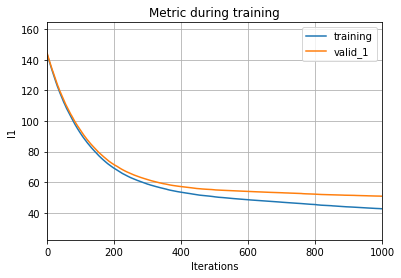

In [31]:
# plot eval results
lgb.plot_metric(evals_result)

In [32]:
# forecasting
df_full['prediction'] = model.predict(df_full[features2train])
df_full['prediction'] = df_full['prediction'] + df_full['mean_dayofweek_even_id']
df_full['prediction'] = np.clip(df_full['prediction'], a_min=0, a_max = None)

In [33]:
# post_processsing
claster = [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 16, 17, 18, 19]
claster_holidays = [pd.to_datetime('2017-06-04')]
all_holidays = [pd.to_datetime('2017-05-01'),
                pd.to_datetime('2017-05-14'),
                pd.to_datetime('2017-05-25'),
                pd.to_datetime('2017-04-03'),
                pd.to_datetime('2017-04-06'),
               ]
    
for shop in claster:
    df_full.loc[(df_full['id'] == shop)
          & (df_full['dt'].isin(claster_holidays)), 
           'prediction'
          ] = 0

df_full.loc[(df_full['dt'].isin(all_holidays)), 
       'prediction'
      ] = 0    

In [34]:
metrics = {}

shops_list = df_full['id'].unique().tolist()
for shop in shops_list:
    shop_df = df_full[df_full['id'] == shop] 
    y_test = shop_df[shop_df['split'] == 'test']['sales'].fillna(0).copy()
    y_pred = shop_df[shop_df['split'] == 'test']['prediction'].copy()
    y_train = shop_df[shop_df['split'] == 'train']['sales'].fillna(0).copy()
    metric =  mean_absolute_scaled_error(y_test, y_pred, y_train = y_train, sp = HORIZON)
    print(f'{shop} : {metric}')
    metrics[shop] = metric

0 : 0.13514638963041634
1 : 0.1316944503070707
2 : 0.14738753854954312
3 : 0.14422244122723016
4 : 0.20185567413963995
5 : 0.16704277037478726
6 : 0.1755750841130383
7 : 0.16198861791648117
8 : 0.21601040155502463
9 : 0.13453662570122712
10 : 0.11592827889967888
11 : 0.13069992710208717
12 : 0.13825582615201243
13 : 0.1907310460155758
14 : 0.12632073089607473
15 : 0.10545645618082564
16 : 0.21384929566251748
17 : 0.15823406591509773
18 : 0.09668754647569092
19 : 0.10339723107840904


In [35]:
# mean metric
np.array(list(metrics.values())).mean()

0.14975101989462142

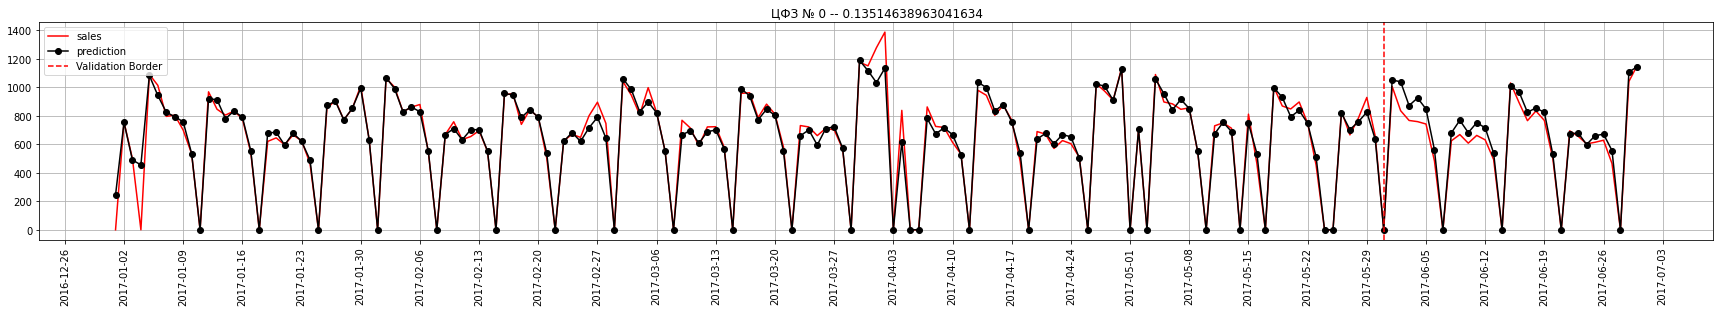

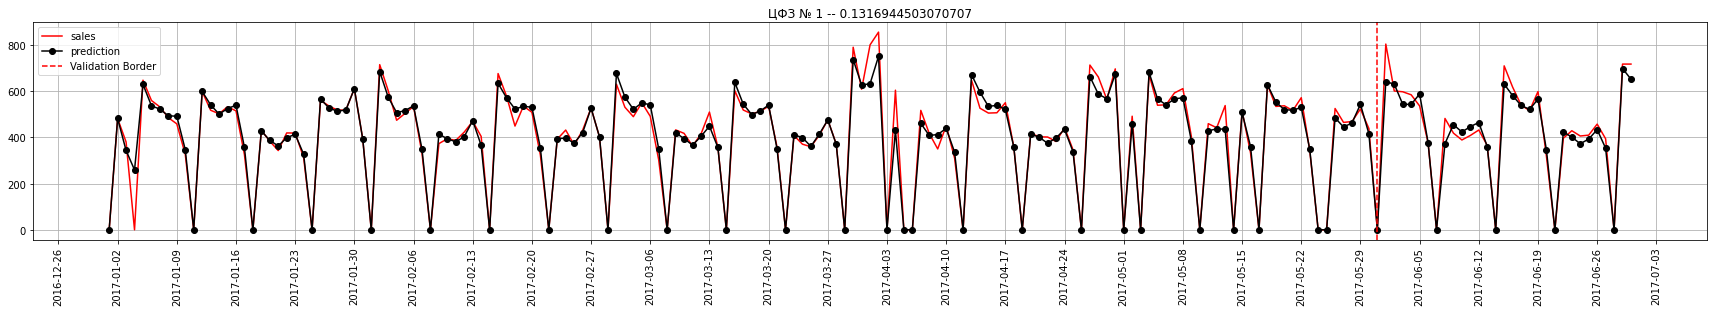

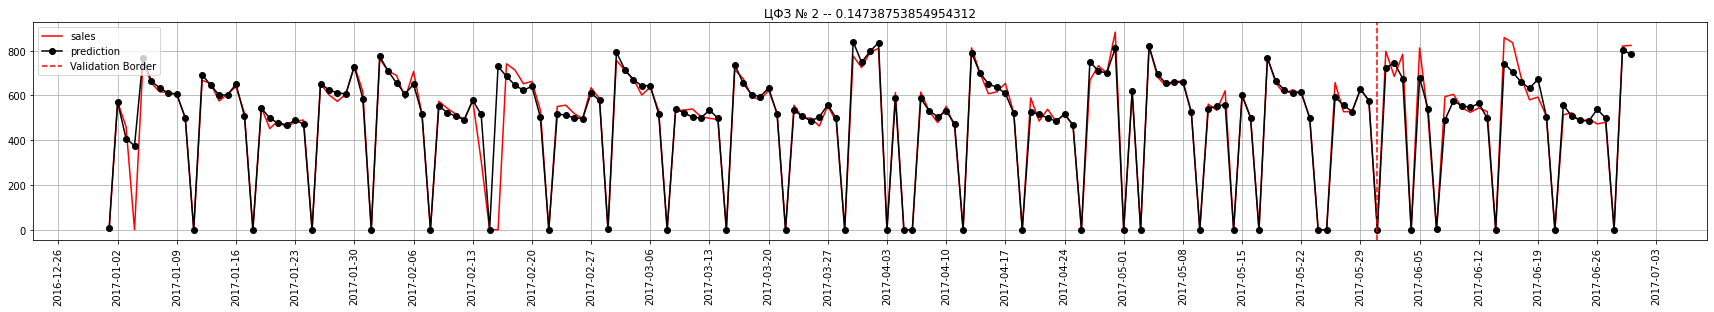

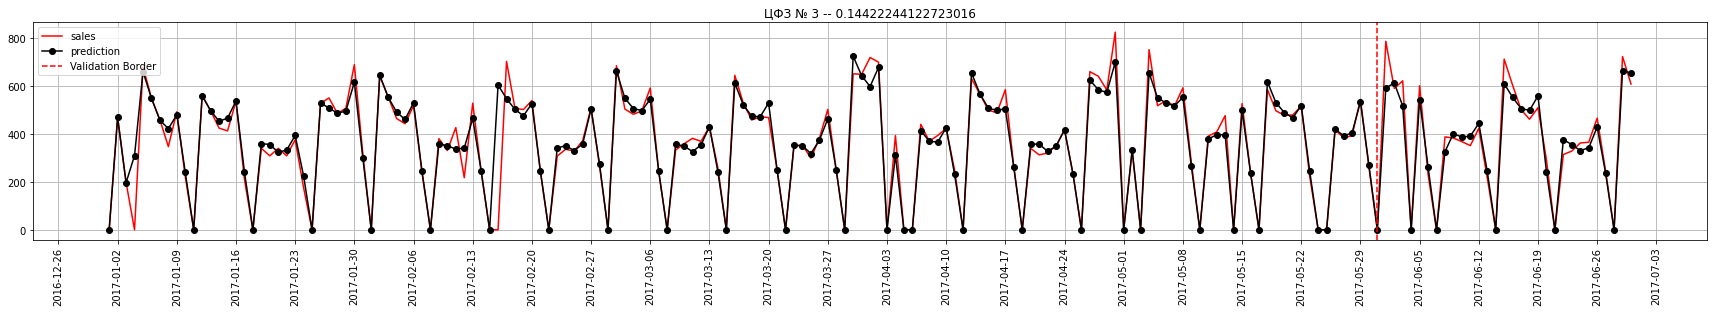

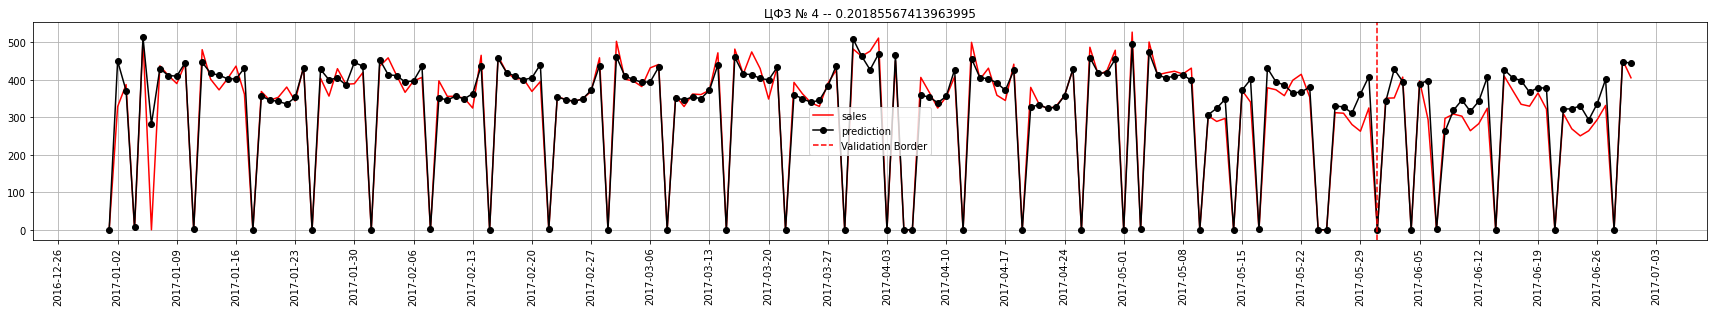

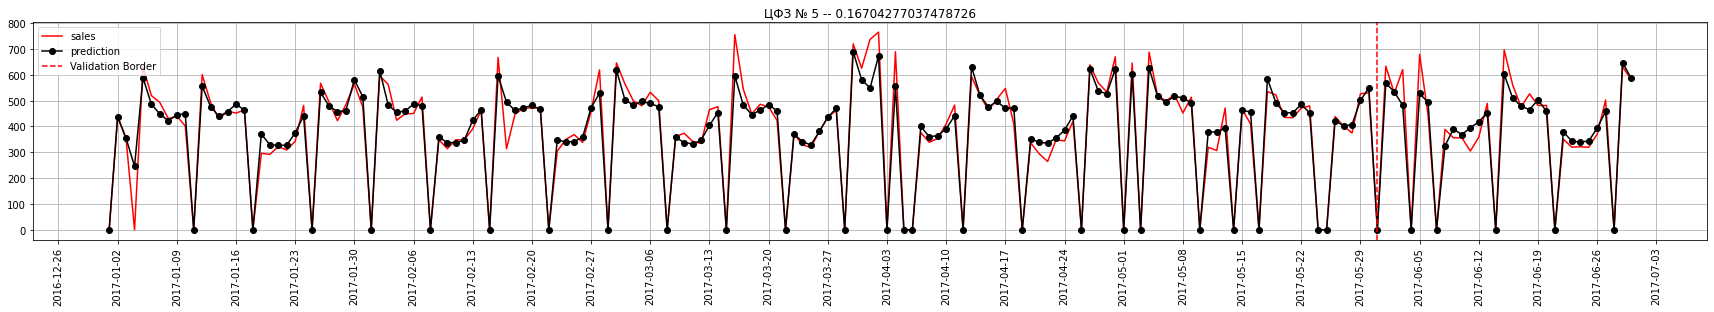

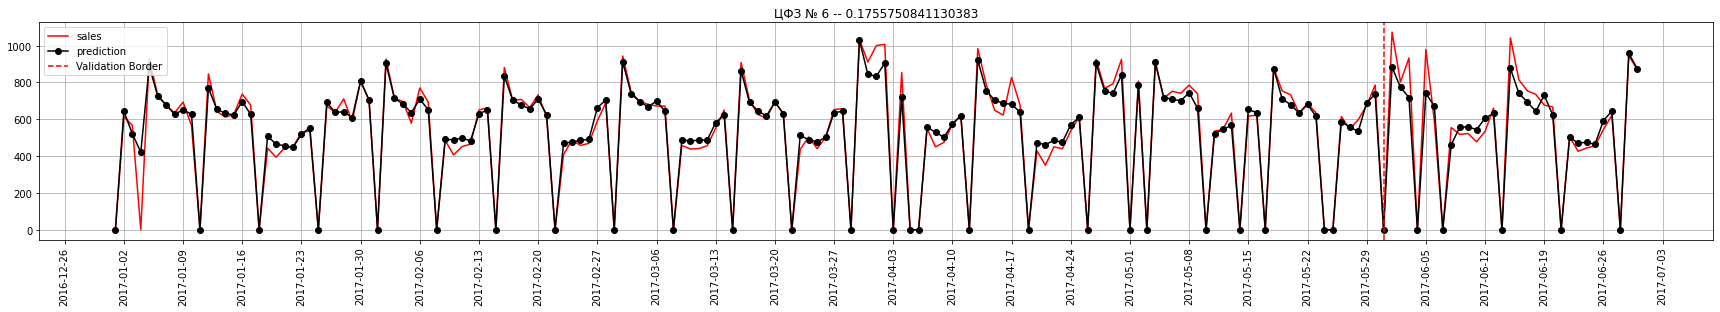

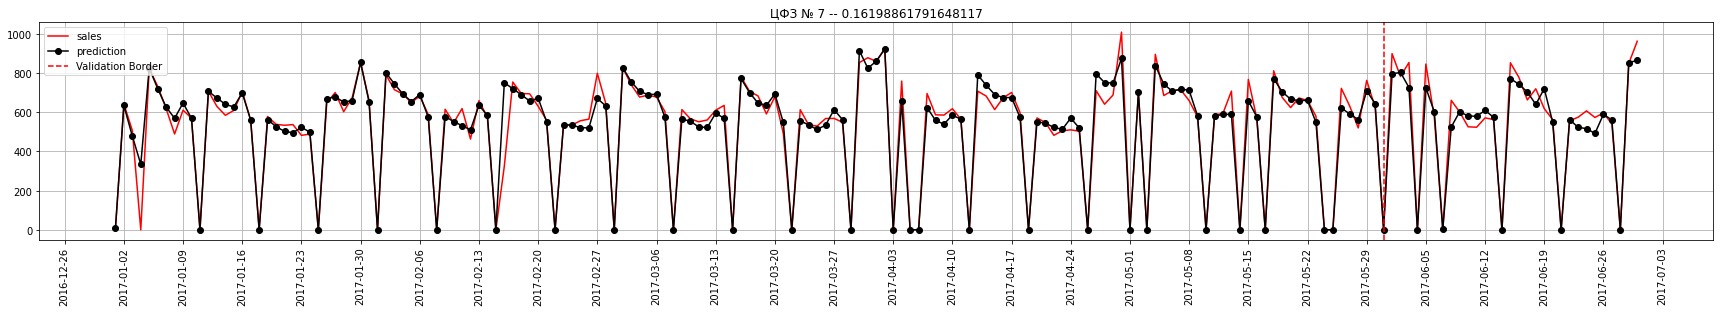

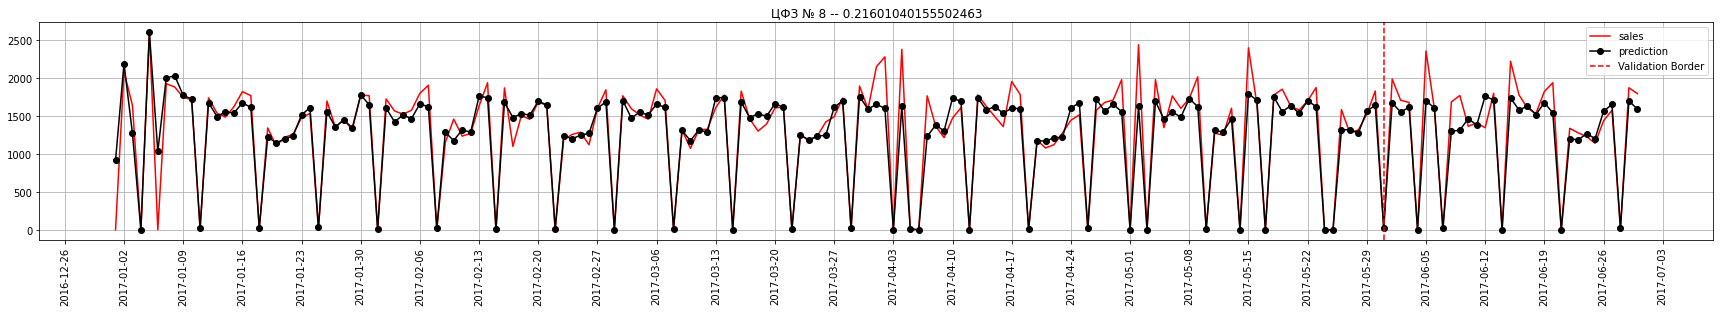

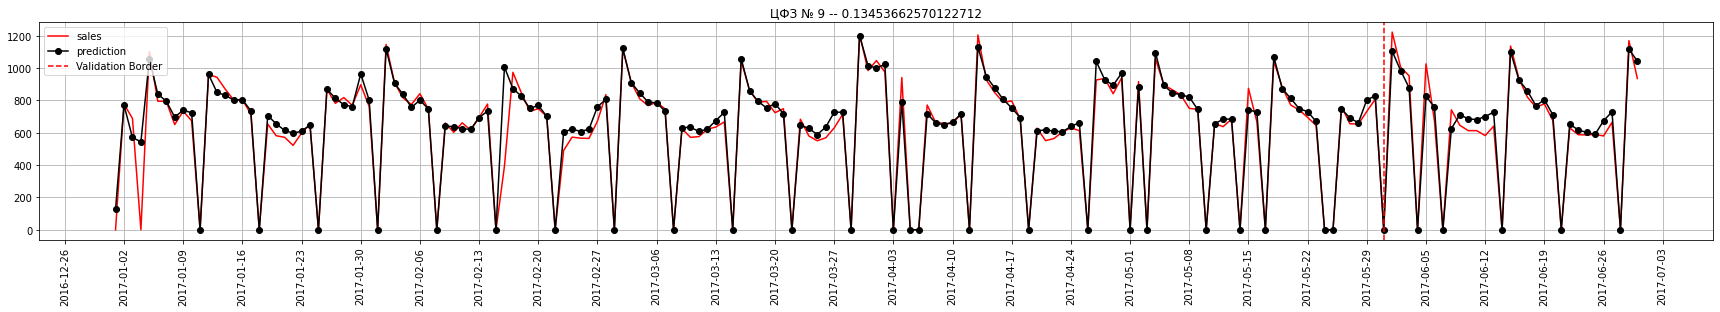

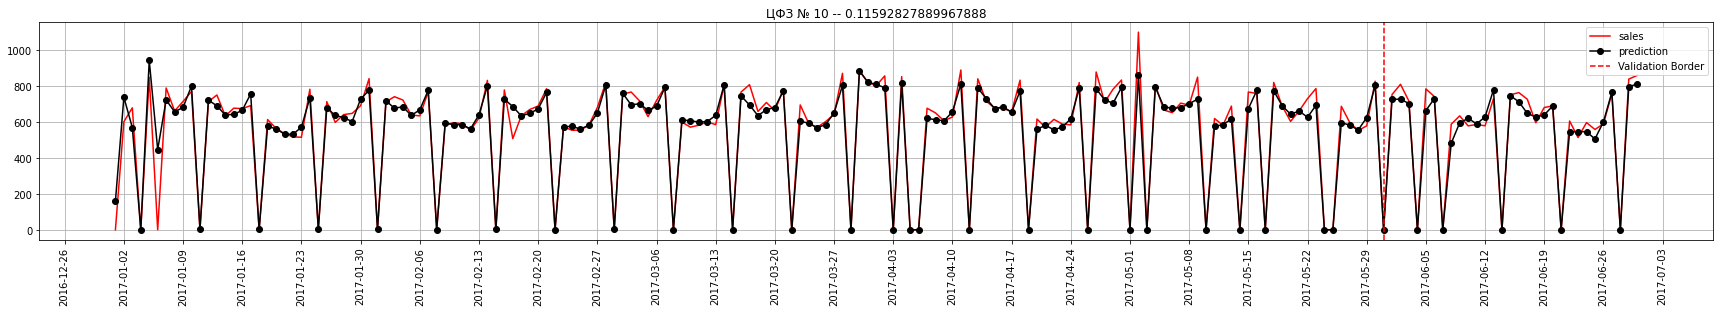

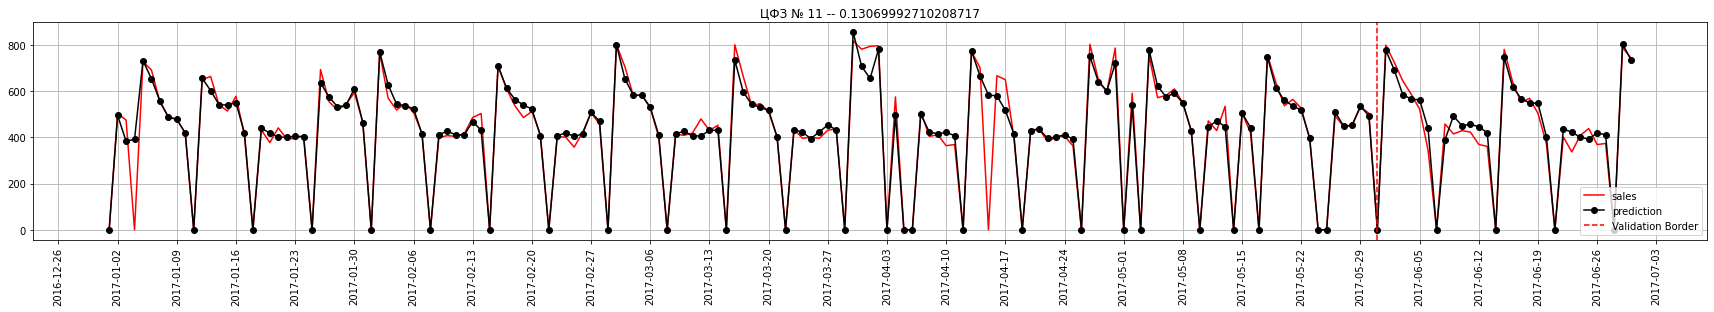

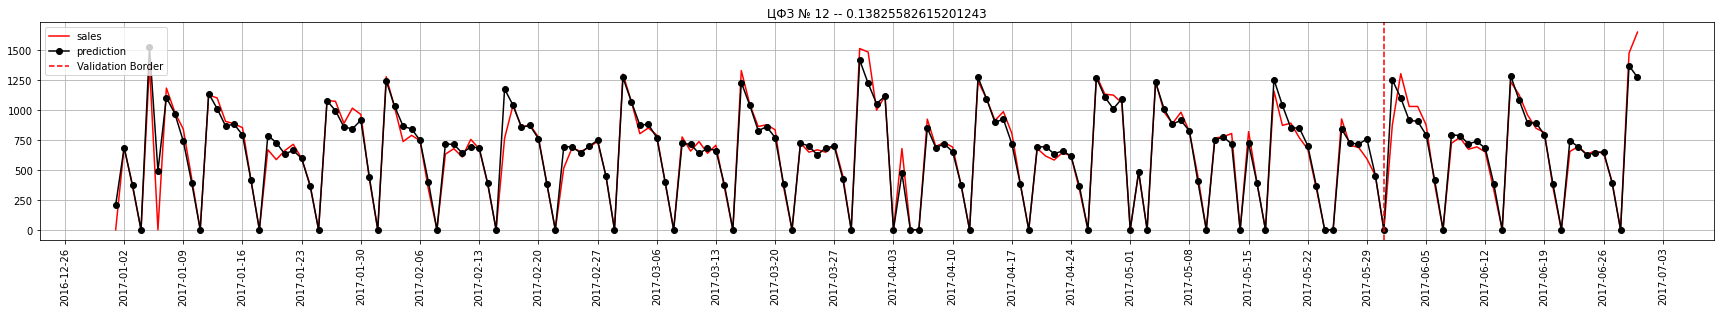

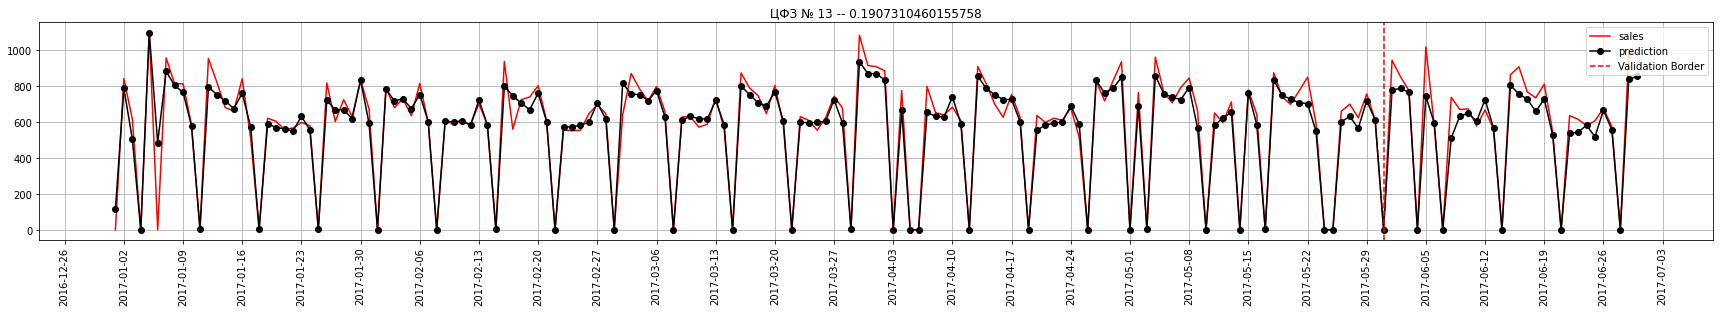

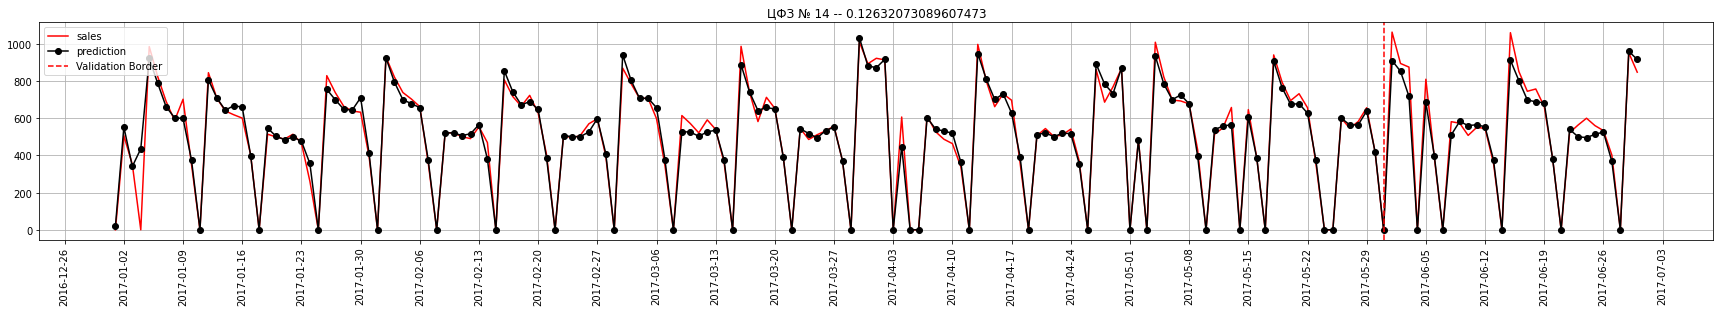

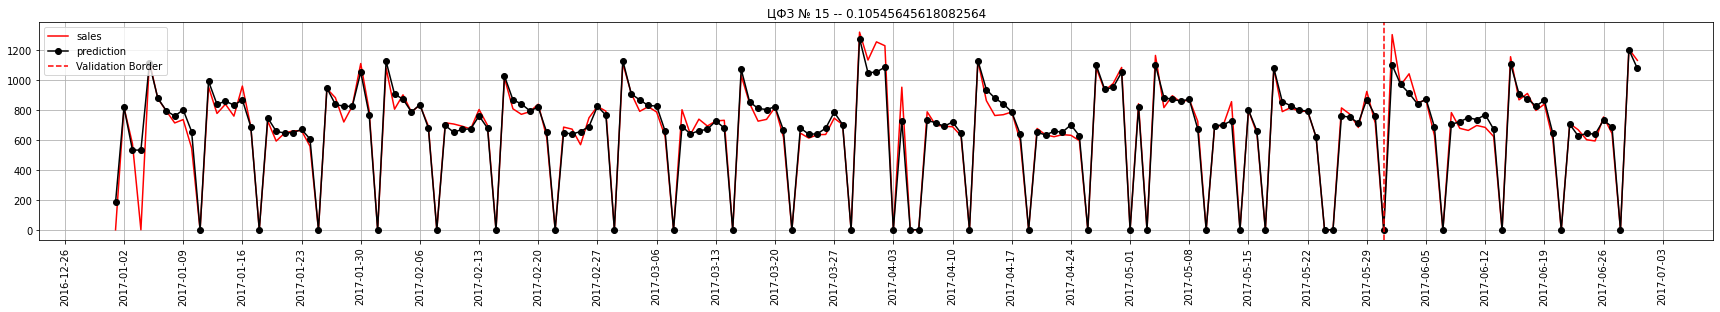

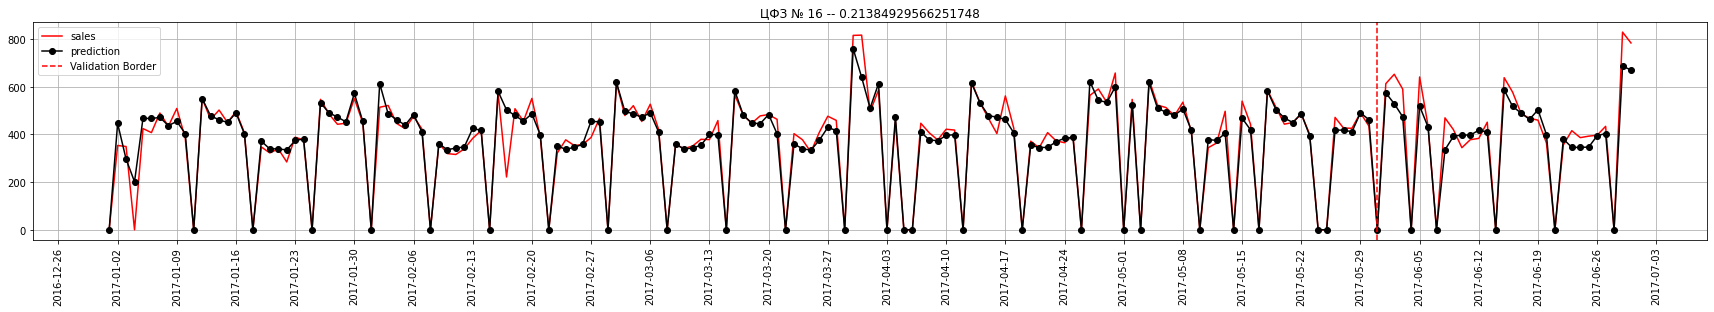

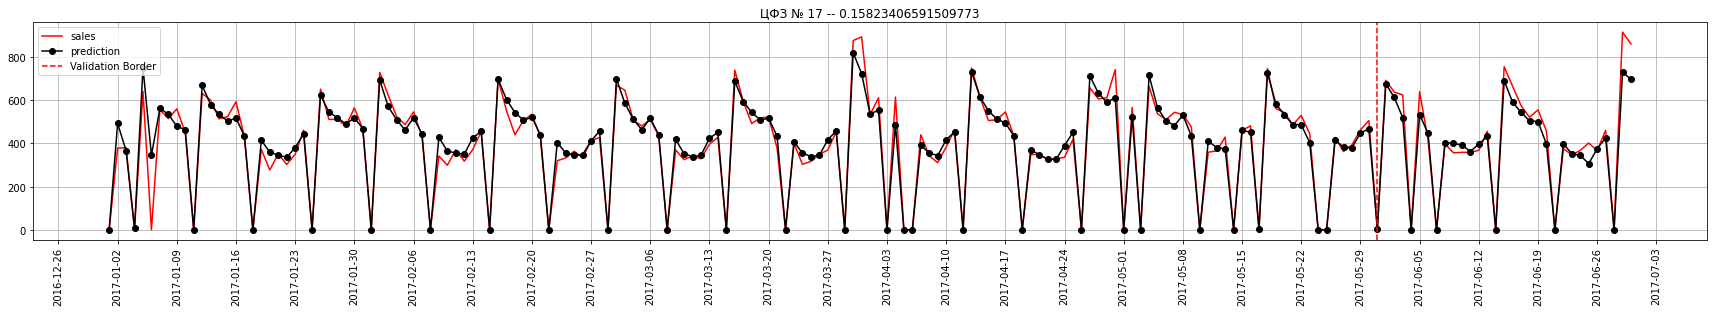

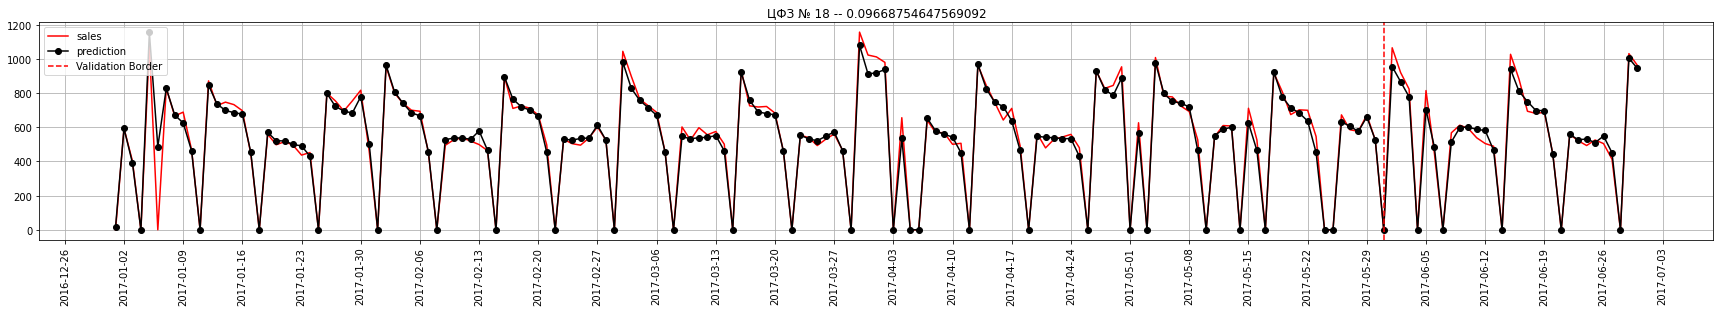

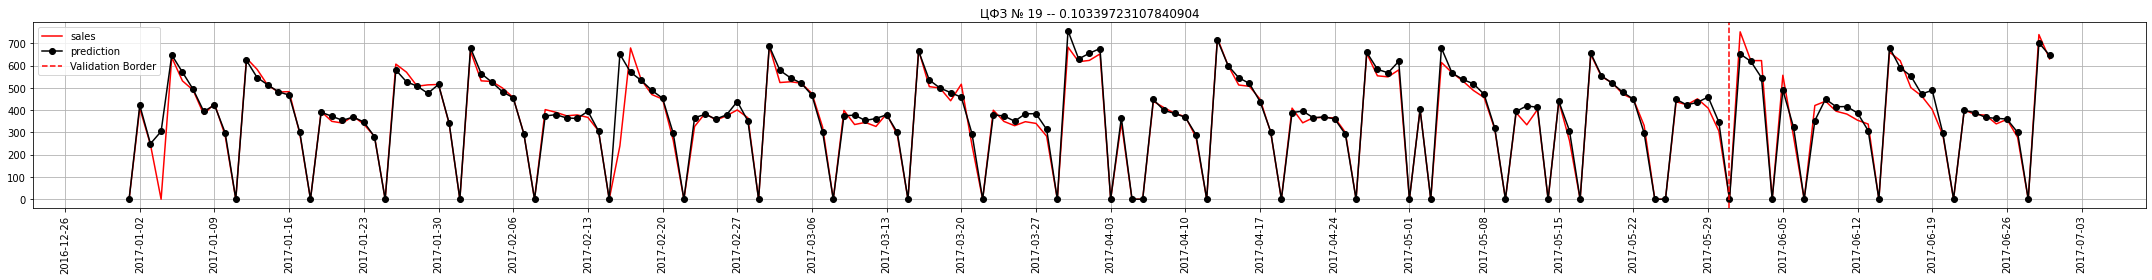

In [36]:
# visualize predicts
dagg = df_full.groupby(['id'], as_index = False)

for name, group in dagg:
    try:
        group = group[group['dt'] >= pd.to_datetime('2017-01-01')]
        df_agg = group.groupby(['dt'], as_index = False).sum()

        fig, ax = plt.subplots(figsize = (30, 4))
        ax.plot(df_agg['dt'], df_agg['sales'], label = 'sales',  color = 'red',)
        ax.plot(df_agg['dt'], df_agg['prediction'], label = 'prediction', color = 'black', marker='o')

        treshold = df[df['split'] == 'train']['dt'].max()

        ax.axvline(treshold, linestyle='--', color='red', label='Validation Border')
        metric = metrics[name]
        ax.set_label('Средний таргет ')
        ax.set_title(f'ЦФЗ № {name} -- {metric}')
        ax.legend()
        ax.grid()
        ax.xaxis.set_major_locator(md.WeekdayLocator(MO))
#         ax.xaxis.set_major_locator(md.MonthLocator())
        ax.xaxis.set_tick_params(rotation=90)
    except:
        continue

plt.tight_layout()